In [18]:
# !ls
# !rm -rf train1111111111111111111111

MakeDimongModel.ipynb  train


In [21]:
# !unzip -uq "DimongTestData.zip1111111111111111" -d "./DimongData"

In [109]:
import os
import re
from glob import glob
from tqdm import tqdm
import numpy as np
import pandas as pd
import ast

# 데이터 시각화를 위해 그래프나 도형을 화면에 출력해줌
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import shutil # shutil == shell utility
%matplotlib inline

In [110]:
# 디렉토리 경로를 저장한 변수
directory_list = [
    # 학습 데이터를 저장할 디렉토리 경로
    './DimongData/train/',
    # 평가 데이터를 저장할 디렉토리 경로
    './DimongData/test/',
]

In [111]:
# PyTorch를 이용한 전이 학습(Transfer Learning)

In [112]:
# 파이토치의 핵심 패키지(모델 구성 및 학습 등을 수행할 수 있는 기능을 제공)
import torch
# PyTorch에서 제공하는 신경망 모듈
import torch.nn as nn
# 학습에 사용되는 최적화 알고리즘
import torch.optim as optim
# PyTorch에서 이미지 데이터 처리와 관련된 함수와 모델들을 제공
import torchvision
# transforms 모듈은 데이터 전처리를 위한 함수들을 제공
from torchvision import datasets, models, transforms
# 다차원 배열을 다루는데 사용
import numpy as np
# 시간과 관련된 함수를 제공
import time


# GPU가 사용 가능한 경우 cuda를 0으로 초기화하여 사용 / GPU가 사용 불가능한 경우 CPU로 초기화하여 CPU 사용
if torch.cuda.is_available():
    device = torch.device("cuda:3")
    print("cuda")
else:
    device = torch.device("cpu")
    print("GPU is not available. Using CPU instead.")

cuda


In [113]:
# 데이터 전처리를 통해 데이터 가공을 하여 모델의 성능을 강화

# 학습데이터를 불러올 때
transforms_train = transforms.Compose([
    # 해상도를 (224,224)로 맞춰준다
    transforms.Resize((224, 224)),
    # 이미지를 좌우로 뒤집어서 데이터 증강(augmentation)을 수행(확률을 높여준)
    transforms.RandomHorizontalFlip(),
    # 이미지를 PyTorch의 Tensor로 변환
    transforms.ToTensor(),
    # 이미지의 RGB 채널 값을 평균과 표준편차를 이용하여 정규화
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # 정규화(normalization)
])

#  테스트데이터를 불러올 때
transforms_test = transforms.Compose([
    # 해상도를 (224,224)로 맞춰준다
    transforms.Resize((224, 224)),
    # 이미지를 PyTorch의 Tensor로 변환
    transforms.ToTensor(),
    # 이미지의 RGB 채널 값을 평균과 표준편차를 이용하여 정규화
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# 데이터가 저장된 경로
data_dir = './DimongData'
print(os.path.join(data_dir, 'train'))
# 데이터가 저장된 경로에서 ImageFolder를 이용하여 이미지 데이터셋을 전처리한 후 로드(transforms_*==전처리 수행)
train_datasets = datasets.ImageFolder(os.path.join(data_dir, 'train'), transforms_train)
test_datasets = datasets.ImageFolder(os.path.join(data_dir, 'test'), transforms_test)
# DataLoader를 이용하여 데이터셋에서 미니배치(minibatch)를 추출 (batch_size==미니배치의 크기 / shuffle==데이터셋을 섞을지 여부 / num_workers==데이터셋을 불러올 때 사용할 프로세스 수)
train_dataloader = torch.utils.data.DataLoader(train_datasets, batch_size=64, shuffle=True, num_workers=4)
test_dataloader = torch.utils.data.DataLoader(test_datasets, batch_size=8, shuffle=True, num_workers=4)
# 수행 결과를 출력
print('학습 데이터셋 크기:', len(train_datasets))
print('테스트 데이터셋 크기:', len(test_datasets))
# 학습된 클래스 이름과 수행 결과를 출력
class_names = train_datasets.classes
print('클래스:', class_names)

./DimongData/train
학습 데이터셋 크기: 4233
테스트 데이터셋 크기: 150
클래스: ['Allosaurus', 'Ankylosaurus', 'Argentinosaurus', 'Brachiosaurus', 'Chasmosaurus', 'Chintaosaurus', 'Compsognathus', 'Dilophosaurus', 'Dimetrodon', 'Dimorphodon', 'Elasmosaurus', 'Giganotosaurus', 'Iguanodon', 'Incisibosaurus', 'Kentrosaurus', 'Lambeosaurus', 'Mosasaurus', 'Nodosaurus', 'Ouranosaurus', 'Oviraptor', 'Pachycephalosaurus', 'Parasaurolophus', 'Pteranodon', 'Quetzalcoatlus', 'Sauropaganax', 'Spinosaurus', 'Stegosaurus', 'Triceratops', 'Tyrannosaurus', 'Velociraptor']


/home/jupyter-j8a105/.local/lib/python3.9/site-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/jupyter-j8a105/.local/lib/python3.9/site-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/jupyter-j8a105/.local/lib/python3.9/site-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


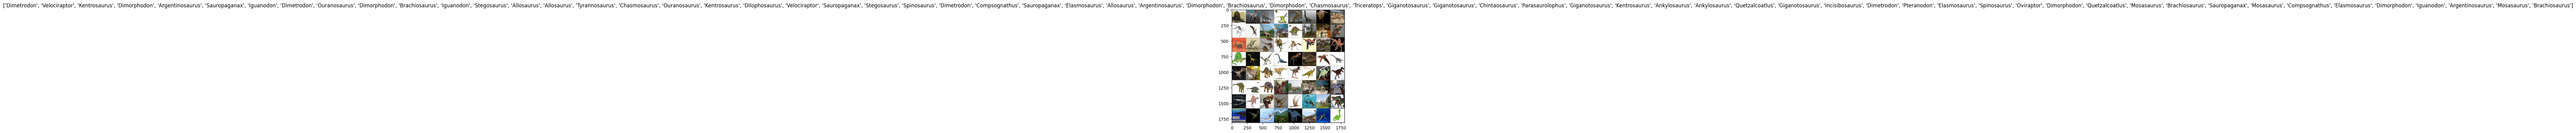

In [114]:
def imshow(input, title):
    # 이미지로 변환해주는 matplotlib(ply)는 numpy 객체만 받을 수 있기 때문에 torch.Tensor를 numpy 객체로 변환
    # pytorh는 (채널, 높이, 너비)의 순서를 갖기 때문에 transpose((1, 2, 0))를 통해 (높이, 너비, 채널)로 순서를 바꿔준다
    input = input.numpy().transpose((1, 2, 0))
    # 데이터셋에서 계산된 평균과 표준편차
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    # 정규화된 이미지 데이터에 평균을 더하고 표준편차를 곱하여 정규화를 해제
    input = std * input + mean
    # 이미지 데이터의 픽셀 값이 0보다 작거나 1보다 클 경우, 0 또는 1로 대체
    input = np.clip(input, 0, 1)
    # matplotlib를 이용하여 이미지 데이터를 출력
    plt.imshow(input)
    # 이미지의 타이틀을 설정
    plt.title(title)
    # 이미지를 보여줌
    plt.show()


# train_dataloader(학습 데이터)를 iterator(배치 단위)로 불러오기
iterator = iter(train_dataloader)

# iterator에서 배치 불러오기
inputs, classes = next(iterator)
# 입력 이미지를 격자 형태로 만들기
out = torchvision.utils.make_grid(inputs)
# imshow==정규화를 해제하고 이미지를 시각화 / title==현재 배치의 정답 클래스
imshow(out, title=[class_names[x] for x in classes])

In [115]:
# 미리 학습된 ResNet-50모델 네트워크 불러오기
model = models.resnet50(pretrained=True)
# 불러온 네트워크 모델의 출력 뉴런 수를 저장
num_features = model.fc.in_features
# 전이 학습(transfer learning): 모델의 출력 뉴런 수를 30개로 교체하여 마지막 레이어 다시 학습
model.fc = nn.Linear(num_features, 30)
# GPU를 사용하기 위해 모델을 CUDA 디바이스로 보냅니다.
model = model.to(device)
# Cross Entropy Loss(분류 문제에서 주로 사용되는 손실 함수) 불러오기
criterion = nn.CrossEntropyLoss()
# Stochastic Gradient Descent(SGD) 최적화 함수를 불러온 후, 학습률(learning rate)과 모멘텀(momentum) 값을 설정합니다.
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

/home/jupyter-j8a105/.local/lib/python3.9/site-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/jupyter-j8a105/.local/lib/python3.9/site-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/jupyter-j8a105/.local/lib/python3.9/site-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/jupyter-j8a105/.local/lib/python3.9/site-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


#0 Loss: 3.2001 Acc: 15.5445% Time: 25.8549s
[Test Phase] Loss: 2.7111 Acc: 38.6667% Time: 28.6566s


/home/jupyter-j8a105/.local/lib/python3.9/site-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/jupyter-j8a105/.local/lib/python3.9/site-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/jupyter-j8a105/.local/lib/python3.9/site-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/jupyter-j8a105/.local/lib/python3.9/site-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


#1 Loss: 1.7338 Acc: 49.6338% Time: 57.4185s
[Test Phase] Loss: 1.0768 Acc: 63.3333% Time: 59.6586s


/home/jupyter-j8a105/.local/lib/python3.9/site-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/jupyter-j8a105/.local/lib/python3.9/site-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/jupyter-j8a105/.local/lib/python3.9/site-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/jupyter-j8a105/.local/lib/python3.9/site-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


#2 Loss: 0.9406 Acc: 70.5410% Time: 88.5795s
[Test Phase] Loss: 0.5278 Acc: 85.3333% Time: 90.9773s


/home/jupyter-j8a105/.local/lib/python3.9/site-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/jupyter-j8a105/.local/lib/python3.9/site-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/jupyter-j8a105/.local/lib/python3.9/site-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/jupyter-j8a105/.local/lib/python3.9/site-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


#3 Loss: 0.6167 Acc: 80.5103% Time: 117.4012s
[Test Phase] Loss: 0.3306 Acc: 91.3333% Time: 119.6867s


/home/jupyter-j8a105/.local/lib/python3.9/site-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/jupyter-j8a105/.local/lib/python3.9/site-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/jupyter-j8a105/.local/lib/python3.9/site-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/jupyter-j8a105/.local/lib/python3.9/site-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


#4 Loss: 0.4161 Acc: 86.1564% Time: 144.3086s
[Test Phase] Loss: 0.3779 Acc: 89.3333% Time: 146.7070s


/home/jupyter-j8a105/.local/lib/python3.9/site-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/jupyter-j8a105/.local/lib/python3.9/site-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/jupyter-j8a105/.local/lib/python3.9/site-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/jupyter-j8a105/.local/lib/python3.9/site-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


#5 Loss: 0.3306 Acc: 89.2275% Time: 172.7737s
[Test Phase] Loss: 0.2607 Acc: 92.0000% Time: 175.1827s


/home/jupyter-j8a105/.local/lib/python3.9/site-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/jupyter-j8a105/.local/lib/python3.9/site-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/jupyter-j8a105/.local/lib/python3.9/site-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/jupyter-j8a105/.local/lib/python3.9/site-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


#6 Loss: 0.1885 Acc: 93.8105% Time: 201.9497s
[Test Phase] Loss: 0.2737 Acc: 95.3333% Time: 204.1769s


/home/jupyter-j8a105/.local/lib/python3.9/site-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/jupyter-j8a105/.local/lib/python3.9/site-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/jupyter-j8a105/.local/lib/python3.9/site-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/jupyter-j8a105/.local/lib/python3.9/site-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


#7 Loss: 0.1850 Acc: 94.1413% Time: 230.7626s
[Test Phase] Loss: 0.2574 Acc: 92.6667% Time: 233.0910s


/home/jupyter-j8a105/.local/lib/python3.9/site-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/jupyter-j8a105/.local/lib/python3.9/site-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/jupyter-j8a105/.local/lib/python3.9/site-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/jupyter-j8a105/.local/lib/python3.9/site-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


#8 Loss: 0.0949 Acc: 96.8816% Time: 260.1573s
[Test Phase] Loss: 0.2091 Acc: 92.6667% Time: 262.6421s


/home/jupyter-j8a105/.local/lib/python3.9/site-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/jupyter-j8a105/.local/lib/python3.9/site-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/jupyter-j8a105/.local/lib/python3.9/site-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/jupyter-j8a105/.local/lib/python3.9/site-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


#9 Loss: 0.0748 Acc: 97.6140% Time: 289.2692s
[Test Phase] Loss: 0.2607 Acc: 94.0000% Time: 291.5066s


/home/jupyter-j8a105/.local/lib/python3.9/site-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/jupyter-j8a105/.local/lib/python3.9/site-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/jupyter-j8a105/.local/lib/python3.9/site-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/jupyter-j8a105/.local/lib/python3.9/site-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


#10 Loss: 0.0665 Acc: 97.9447% Time: 317.8650s
[Test Phase] Loss: 0.1066 Acc: 96.6667% Time: 320.3420s


/home/jupyter-j8a105/.local/lib/python3.9/site-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/jupyter-j8a105/.local/lib/python3.9/site-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/jupyter-j8a105/.local/lib/python3.9/site-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/jupyter-j8a105/.local/lib/python3.9/site-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


#11 Loss: 0.0458 Acc: 98.7716% Time: 347.4580s
[Test Phase] Loss: 0.1467 Acc: 96.6667% Time: 350.1430s


/home/jupyter-j8a105/.local/lib/python3.9/site-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/jupyter-j8a105/.local/lib/python3.9/site-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/jupyter-j8a105/.local/lib/python3.9/site-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/jupyter-j8a105/.local/lib/python3.9/site-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


#12 Loss: 0.0529 Acc: 98.3936% Time: 375.8873s
[Test Phase] Loss: 0.1316 Acc: 98.0000% Time: 378.1650s


/home/jupyter-j8a105/.local/lib/python3.9/site-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/jupyter-j8a105/.local/lib/python3.9/site-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/jupyter-j8a105/.local/lib/python3.9/site-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/jupyter-j8a105/.local/lib/python3.9/site-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


#13 Loss: 0.1266 Acc: 96.1729% Time: 405.1390s
[Test Phase] Loss: 0.0967 Acc: 98.0000% Time: 407.4724s


/home/jupyter-j8a105/.local/lib/python3.9/site-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/jupyter-j8a105/.local/lib/python3.9/site-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/jupyter-j8a105/.local/lib/python3.9/site-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/jupyter-j8a105/.local/lib/python3.9/site-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


#14 Loss: 0.0353 Acc: 98.8424% Time: 434.4421s
[Test Phase] Loss: 0.1457 Acc: 95.3333% Time: 436.9435s


/home/jupyter-j8a105/.local/lib/python3.9/site-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/jupyter-j8a105/.local/lib/python3.9/site-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/jupyter-j8a105/.local/lib/python3.9/site-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/jupyter-j8a105/.local/lib/python3.9/site-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


#15 Loss: 0.0350 Acc: 98.9842% Time: 462.9040s
[Test Phase] Loss: 0.1137 Acc: 96.6667% Time: 465.2486s


/home/jupyter-j8a105/.local/lib/python3.9/site-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/jupyter-j8a105/.local/lib/python3.9/site-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/jupyter-j8a105/.local/lib/python3.9/site-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/jupyter-j8a105/.local/lib/python3.9/site-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


#16 Loss: 0.0177 Acc: 99.4330% Time: 491.5289s
[Test Phase] Loss: 0.0506 Acc: 97.3333% Time: 494.0604s


/home/jupyter-j8a105/.local/lib/python3.9/site-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/jupyter-j8a105/.local/lib/python3.9/site-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/jupyter-j8a105/.local/lib/python3.9/site-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/jupyter-j8a105/.local/lib/python3.9/site-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


#17 Loss: 0.0291 Acc: 99.2440% Time: 520.0497s
[Test Phase] Loss: 0.1377 Acc: 98.6667% Time: 522.4577s


/home/jupyter-j8a105/.local/lib/python3.9/site-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/jupyter-j8a105/.local/lib/python3.9/site-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/jupyter-j8a105/.local/lib/python3.9/site-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/jupyter-j8a105/.local/lib/python3.9/site-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


#18 Loss: 0.0121 Acc: 99.7874% Time: 548.3071s
[Test Phase] Loss: 0.1289 Acc: 98.0000% Time: 550.9255s


/home/jupyter-j8a105/.local/lib/python3.9/site-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/jupyter-j8a105/.local/lib/python3.9/site-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/jupyter-j8a105/.local/lib/python3.9/site-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/jupyter-j8a105/.local/lib/python3.9/site-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


#19 Loss: 0.0074 Acc: 99.8346% Time: 576.6234s
[Test Phase] Loss: 0.1064 Acc: 98.0000% Time: 579.0869s


/home/jupyter-j8a105/.local/lib/python3.9/site-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/jupyter-j8a105/.local/lib/python3.9/site-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/jupyter-j8a105/.local/lib/python3.9/site-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/jupyter-j8a105/.local/lib/python3.9/site-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


#20 Loss: 0.0049 Acc: 99.8819% Time: 605.9370s
[Test Phase] Loss: 0.0701 Acc: 98.6667% Time: 608.3119s


/home/jupyter-j8a105/.local/lib/python3.9/site-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/jupyter-j8a105/.local/lib/python3.9/site-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/jupyter-j8a105/.local/lib/python3.9/site-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/jupyter-j8a105/.local/lib/python3.9/site-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


#21 Loss: 0.0049 Acc: 99.8819% Time: 634.4296s
[Test Phase] Loss: 0.0516 Acc: 98.6667% Time: 636.7754s


/home/jupyter-j8a105/.local/lib/python3.9/site-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/jupyter-j8a105/.local/lib/python3.9/site-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/jupyter-j8a105/.local/lib/python3.9/site-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/jupyter-j8a105/.local/lib/python3.9/site-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


#22 Loss: 0.0036 Acc: 99.8583% Time: 663.0934s
[Test Phase] Loss: 0.0749 Acc: 98.6667% Time: 665.5966s


/home/jupyter-j8a105/.local/lib/python3.9/site-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/jupyter-j8a105/.local/lib/python3.9/site-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/jupyter-j8a105/.local/lib/python3.9/site-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/jupyter-j8a105/.local/lib/python3.9/site-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


#23 Loss: 0.0033 Acc: 99.8819% Time: 694.5015s
[Test Phase] Loss: 0.0559 Acc: 98.6667% Time: 696.8383s


/home/jupyter-j8a105/.local/lib/python3.9/site-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/jupyter-j8a105/.local/lib/python3.9/site-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/jupyter-j8a105/.local/lib/python3.9/site-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/jupyter-j8a105/.local/lib/python3.9/site-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


#24 Loss: 0.0024 Acc: 99.8819% Time: 724.5517s
[Test Phase] Loss: 0.0900 Acc: 98.6667% Time: 727.3079s


/home/jupyter-j8a105/.local/lib/python3.9/site-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/jupyter-j8a105/.local/lib/python3.9/site-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/jupyter-j8a105/.local/lib/python3.9/site-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/jupyter-j8a105/.local/lib/python3.9/site-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


#25 Loss: 0.0034 Acc: 99.8346% Time: 753.7444s
[Test Phase] Loss: 0.0396 Acc: 99.3333% Time: 756.1331s


/home/jupyter-j8a105/.local/lib/python3.9/site-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/jupyter-j8a105/.local/lib/python3.9/site-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/jupyter-j8a105/.local/lib/python3.9/site-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/jupyter-j8a105/.local/lib/python3.9/site-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


#26 Loss: 0.0279 Acc: 99.2913% Time: 782.3472s
[Test Phase] Loss: 0.0837 Acc: 98.0000% Time: 784.7681s


/home/jupyter-j8a105/.local/lib/python3.9/site-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/jupyter-j8a105/.local/lib/python3.9/site-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/jupyter-j8a105/.local/lib/python3.9/site-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/jupyter-j8a105/.local/lib/python3.9/site-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


#27 Loss: 0.0069 Acc: 99.8110% Time: 810.8716s
[Test Phase] Loss: 0.1187 Acc: 98.0000% Time: 813.2321s


/home/jupyter-j8a105/.local/lib/python3.9/site-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/jupyter-j8a105/.local/lib/python3.9/site-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/jupyter-j8a105/.local/lib/python3.9/site-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/jupyter-j8a105/.local/lib/python3.9/site-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


#28 Loss: 0.0038 Acc: 99.8819% Time: 841.4663s
[Test Phase] Loss: 0.0896 Acc: 98.0000% Time: 844.1543s


/home/jupyter-j8a105/.local/lib/python3.9/site-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/jupyter-j8a105/.local/lib/python3.9/site-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/jupyter-j8a105/.local/lib/python3.9/site-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/jupyter-j8a105/.local/lib/python3.9/site-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


#29 Loss: 0.0027 Acc: 99.8346% Time: 872.6280s
[Test Phase] Loss: 0.0841 Acc: 98.6667% Time: 875.4541s


/home/jupyter-j8a105/.local/lib/python3.9/site-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/jupyter-j8a105/.local/lib/python3.9/site-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/jupyter-j8a105/.local/lib/python3.9/site-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/jupyter-j8a105/.local/lib/python3.9/site-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


#30 Loss: 0.0023 Acc: 99.9291% Time: 902.8889s
[Test Phase] Loss: 0.0961 Acc: 98.0000% Time: 905.6013s


/home/jupyter-j8a105/.local/lib/python3.9/site-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/jupyter-j8a105/.local/lib/python3.9/site-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/jupyter-j8a105/.local/lib/python3.9/site-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/jupyter-j8a105/.local/lib/python3.9/site-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


#31 Loss: 0.0025 Acc: 99.8583% Time: 934.5398s
[Test Phase] Loss: 0.0912 Acc: 98.0000% Time: 937.2190s


/home/jupyter-j8a105/.local/lib/python3.9/site-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/jupyter-j8a105/.local/lib/python3.9/site-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/jupyter-j8a105/.local/lib/python3.9/site-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/jupyter-j8a105/.local/lib/python3.9/site-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


#32 Loss: 0.0035 Acc: 99.8583% Time: 965.1844s
[Test Phase] Loss: 0.0650 Acc: 98.6667% Time: 967.9164s


/home/jupyter-j8a105/.local/lib/python3.9/site-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/jupyter-j8a105/.local/lib/python3.9/site-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/jupyter-j8a105/.local/lib/python3.9/site-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/jupyter-j8a105/.local/lib/python3.9/site-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


#33 Loss: 0.0022 Acc: 99.8583% Time: 999.7659s
[Test Phase] Loss: 0.0822 Acc: 98.0000% Time: 1002.1095s


/home/jupyter-j8a105/.local/lib/python3.9/site-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/jupyter-j8a105/.local/lib/python3.9/site-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/jupyter-j8a105/.local/lib/python3.9/site-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/jupyter-j8a105/.local/lib/python3.9/site-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


#34 Loss: 0.0025 Acc: 99.8583% Time: 1030.0568s
[Test Phase] Loss: 0.0794 Acc: 98.0000% Time: 1032.8116s


/home/jupyter-j8a105/.local/lib/python3.9/site-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/jupyter-j8a105/.local/lib/python3.9/site-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/jupyter-j8a105/.local/lib/python3.9/site-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/jupyter-j8a105/.local/lib/python3.9/site-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


#35 Loss: 0.0020 Acc: 99.9055% Time: 1061.4535s
[Test Phase] Loss: 0.0782 Acc: 98.0000% Time: 1064.0154s


/home/jupyter-j8a105/.local/lib/python3.9/site-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/jupyter-j8a105/.local/lib/python3.9/site-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/jupyter-j8a105/.local/lib/python3.9/site-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/jupyter-j8a105/.local/lib/python3.9/site-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


#36 Loss: 0.0023 Acc: 99.8819% Time: 1094.0370s
[Test Phase] Loss: 0.0881 Acc: 98.0000% Time: 1096.5657s


/home/jupyter-j8a105/.local/lib/python3.9/site-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/jupyter-j8a105/.local/lib/python3.9/site-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/jupyter-j8a105/.local/lib/python3.9/site-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/jupyter-j8a105/.local/lib/python3.9/site-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


#37 Loss: 0.0018 Acc: 99.9055% Time: 1127.0167s
[Test Phase] Loss: 0.0795 Acc: 98.6667% Time: 1129.8968s


/home/jupyter-j8a105/.local/lib/python3.9/site-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/jupyter-j8a105/.local/lib/python3.9/site-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/jupyter-j8a105/.local/lib/python3.9/site-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/jupyter-j8a105/.local/lib/python3.9/site-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


#38 Loss: 0.0026 Acc: 99.8583% Time: 1159.6858s
[Test Phase] Loss: 0.1036 Acc: 98.0000% Time: 1162.4769s


/home/jupyter-j8a105/.local/lib/python3.9/site-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/jupyter-j8a105/.local/lib/python3.9/site-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/jupyter-j8a105/.local/lib/python3.9/site-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/jupyter-j8a105/.local/lib/python3.9/site-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


#39 Loss: 0.0023 Acc: 99.9055% Time: 1195.8387s
[Test Phase] Loss: 0.0842 Acc: 98.0000% Time: 1198.1094s


/home/jupyter-j8a105/.local/lib/python3.9/site-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/jupyter-j8a105/.local/lib/python3.9/site-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/jupyter-j8a105/.local/lib/python3.9/site-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/jupyter-j8a105/.local/lib/python3.9/site-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


#40 Loss: 0.0018 Acc: 99.8819% Time: 1225.3326s
[Test Phase] Loss: 0.0882 Acc: 98.6667% Time: 1227.9327s


/home/jupyter-j8a105/.local/lib/python3.9/site-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/jupyter-j8a105/.local/lib/python3.9/site-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/jupyter-j8a105/.local/lib/python3.9/site-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/jupyter-j8a105/.local/lib/python3.9/site-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


#41 Loss: 0.0025 Acc: 99.8346% Time: 1256.4577s
[Test Phase] Loss: 0.0762 Acc: 98.6667% Time: 1259.0874s


/home/jupyter-j8a105/.local/lib/python3.9/site-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/jupyter-j8a105/.local/lib/python3.9/site-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/jupyter-j8a105/.local/lib/python3.9/site-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/jupyter-j8a105/.local/lib/python3.9/site-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


#42 Loss: 0.0022 Acc: 99.9055% Time: 1288.1846s
[Test Phase] Loss: 0.0911 Acc: 98.0000% Time: 1290.8893s


/home/jupyter-j8a105/.local/lib/python3.9/site-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/jupyter-j8a105/.local/lib/python3.9/site-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/jupyter-j8a105/.local/lib/python3.9/site-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/jupyter-j8a105/.local/lib/python3.9/site-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


#43 Loss: 0.0020 Acc: 99.8583% Time: 1320.1813s
[Test Phase] Loss: 0.0941 Acc: 98.0000% Time: 1322.8080s


/home/jupyter-j8a105/.local/lib/python3.9/site-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/jupyter-j8a105/.local/lib/python3.9/site-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/jupyter-j8a105/.local/lib/python3.9/site-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/jupyter-j8a105/.local/lib/python3.9/site-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


#44 Loss: 0.0022 Acc: 99.8346% Time: 1351.6019s
[Test Phase] Loss: 0.0971 Acc: 98.0000% Time: 1354.4138s


/home/jupyter-j8a105/.local/lib/python3.9/site-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/jupyter-j8a105/.local/lib/python3.9/site-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/jupyter-j8a105/.local/lib/python3.9/site-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/jupyter-j8a105/.local/lib/python3.9/site-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


#45 Loss: 0.0016 Acc: 99.8819% Time: 1383.2164s
[Test Phase] Loss: 0.0796 Acc: 98.0000% Time: 1385.8817s


/home/jupyter-j8a105/.local/lib/python3.9/site-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/jupyter-j8a105/.local/lib/python3.9/site-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/jupyter-j8a105/.local/lib/python3.9/site-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/jupyter-j8a105/.local/lib/python3.9/site-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


#46 Loss: 0.0021 Acc: 99.8583% Time: 1415.5792s
[Test Phase] Loss: 0.0858 Acc: 98.6667% Time: 1418.4256s


/home/jupyter-j8a105/.local/lib/python3.9/site-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/jupyter-j8a105/.local/lib/python3.9/site-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/jupyter-j8a105/.local/lib/python3.9/site-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/jupyter-j8a105/.local/lib/python3.9/site-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


#47 Loss: 0.0031 Acc: 99.8583% Time: 1447.6120s
[Test Phase] Loss: 0.0970 Acc: 98.0000% Time: 1450.2517s


/home/jupyter-j8a105/.local/lib/python3.9/site-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/jupyter-j8a105/.local/lib/python3.9/site-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/jupyter-j8a105/.local/lib/python3.9/site-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/jupyter-j8a105/.local/lib/python3.9/site-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


#48 Loss: 0.0031 Acc: 99.8819% Time: 1479.8785s
[Test Phase] Loss: 0.0850 Acc: 98.6667% Time: 1482.6327s


/home/jupyter-j8a105/.local/lib/python3.9/site-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/jupyter-j8a105/.local/lib/python3.9/site-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/jupyter-j8a105/.local/lib/python3.9/site-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/jupyter-j8a105/.local/lib/python3.9/site-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


#49 Loss: 0.0025 Acc: 99.8819% Time: 1511.0357s
[Test Phase] Loss: 0.0883 Acc: 98.6667% Time: 1513.5906s


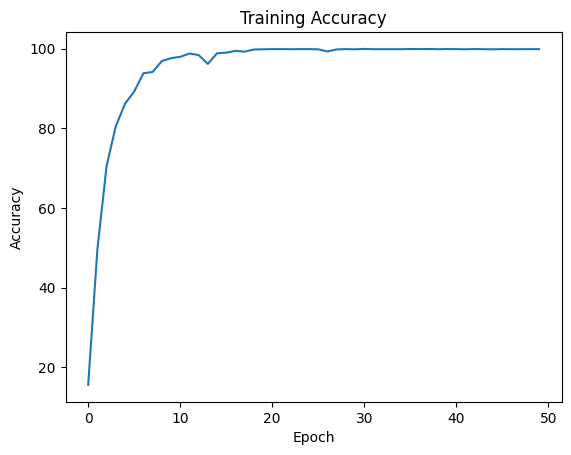

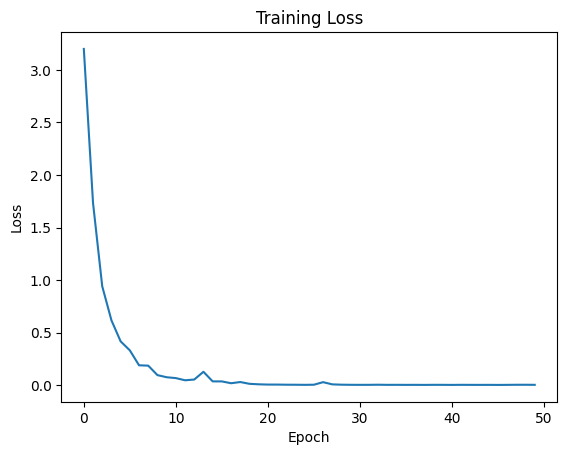

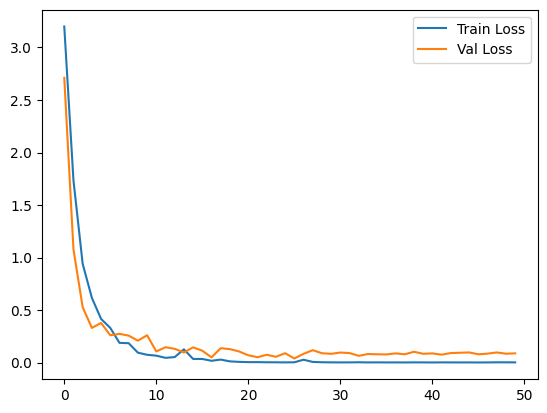

In [116]:
# 전체 학습 과정을 몇 번 반복할지를 정하기
num_epochs = 50
# 모델을 학습모드로 설정
model.train()
# 현재 시간을 저장
start_time = time.time()

# epoch에 따른 손실 값과 정확도를 저장하는 리스트
train_losses = []
train_accs = []
# 손실 값을 저장할 리스트
val_losses = []

# 전체 반복(epoch) 수 만큼 반복하며
for epoch in range(num_epochs):
    #------------training-------------------
    # 현재까지 누적된 손실 값
    running_loss = 0.
    # 현재까지 맞춘 총 이미지 개수
    running_corrects = 0

    # 배치 단위로 나눈 학습 데이터 순회하며 불러와서
    for inputs, labels in train_dataloader:
        # 입력 이미지 데이터 / GPU를 사용하기 위해 .to(device) 메소드를 사용
        inputs = inputs.to(device)
        # 해당 이미지의 정답 라벨
        labels = labels.to(device)

        # 학습이 이루어지는 부분
        # 학습을 하기 전에 이전 학습에서 계산된 gradient 값을 0으로 초기화
        optimizer.zero_grad()
        # 모델에 학습 데이터를 입력 (forward propagation이 이루어지며, 모델은 입력을 받아 출력값을 계산)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        # 모델이 예측한 출력값 outputs와 실제 정답인 라벨 labels를 비교하여 손실 값을 계산
        loss = criterion(outputs, labels)

        # 역전파를 통해 기울기(gradient) 계산 및 학습 진행
        # 손실 값의 gradient를 계산(backward propagation이 이루어지며, 손실 함수를 모델의 출력값으로 미분한 gradient 값을 계산)
        loss.backward()
        # optimization - 계산된 gradient 값을 이용하여 모델의 파라미터를 업데이트
        optimizer.step()

        # 이번 배치에서 계산된 손실 값과 정확도를 running_loss와 running_corrects 변수에 더함
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

    # 모든 배치에서 계산된 손실 값과 정확도를 이용하여 epoch 단위로 평균 손실 값과 정확도를 계산
    epoch_loss = running_loss / len(train_datasets)
    epoch_acc = running_corrects / len(train_datasets) * 100.
    
    # epoch 단위로 평균 손실 값과 정확도를 계산하여 리스트에 추가
    train_losses.append(epoch_loss)
    train_accs.append(epoch_acc)

    # 학습 과정 중에 결과 출력
    print('#{} Loss: {:.4f} Acc: {:.4f}% Time: {:.4f}s'.format(epoch, epoch_loss, epoch_acc, time.time() - start_time))
    
    
    # --------validation----------------
    # 모델을 평가 모드로 설정
    model.eval()

    # PyTorch의 연산 그래프에서 이전 계산에서 계산한 gradient를 기록하지 않고 연산을 수행하는 context 
    # 테스트 단계에서 모델의 평가를 수행할 때 사용
    with torch.no_grad():
        # 각각 전체 loss와 정확도를 누적하는 변수
        # 테스트 데이터셋의 모든 배치를 순회하면서 모델의 예측과 정답을 비교하여 loss와 정확도를 누적
        running_loss = 0.
        running_corrects = 0

        # 배치 단위로 나눈 학습 데이터 순회하며 불러와서
        for inputs, labels in test_dataloader:
            # 입력 이미지 데이터 / GPU를 사용하기 위해 .to(device) 메소드를 사용
            inputs = inputs.to(device)
            # 해당 이미지의 정답 라벨
            labels = labels.to(device)

            # 모델에 학습 데이터를 입력 (forward propagation이 이루어지며, 모델은 입력을 받아 출력값을 계산)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            # 모델이 예측한 출력값 outputs와 실제 정답인 라벨 labels를 비교하여 손실 값을 계산
            loss = criterion(outputs, labels)

            # 이번 배치에서 계산된 손실 값과 정확도를 running_loss와 running_corrects 변수에 더함
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

#             # 이미지의 예측결과와 실제 정답을 출력
#             print(f'[예측 결과: {class_names[preds[0]]}, {class_names[preds[1]]}] (실제 정답: {class_names[labels.data[0]]})')
#             # 해당 이미지를 출력하고 예측결과를 같이 보여줌
#             imshow(inputs.cpu().data[0], title='예측 결과: ' + class_names[preds[0]])

        # 모든 배치에서 계산된 손실 값과 정확도를 이용하여 epoch 단위로 평균 손실 값과 정확도를 계산
        epoch_loss = running_loss / len(test_datasets)
        epoch_acc = running_corrects / len(test_datasets) * 100.

        # 손실값을 데이터에 append
        val_losses.append(epoch_loss)


        # 테스트 과정 중에 결과 출력
        print('[Test Phase] Loss: {:.4f} Acc: {:.4f}% Time: {:.4f}s'.format(epoch_loss, epoch_acc, time.time() - start_time))


# 정확도 그래프 그리기
plt.plot(torch.Tensor(train_accs).cpu())
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()
    
# 손실 값 그래프 그리기
plt.plot(torch.from_numpy(np.array(train_losses)))
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

# 과적합 그래프 그리기
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.legend()
plt.show()

[예측 결과: Ouranosaurus, Tyrannosaurus] (실제 정답: Ouranosaurus)


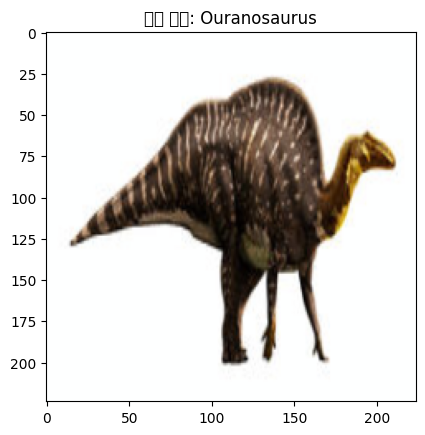

[예측 결과: Dilophosaurus, Chasmosaurus] (실제 정답: Dilophosaurus)


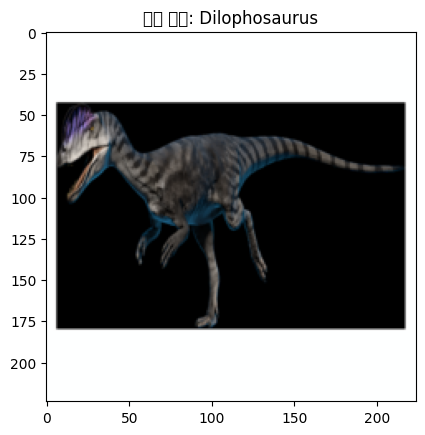

[예측 결과: Elasmosaurus, Mosasaurus] (실제 정답: Elasmosaurus)


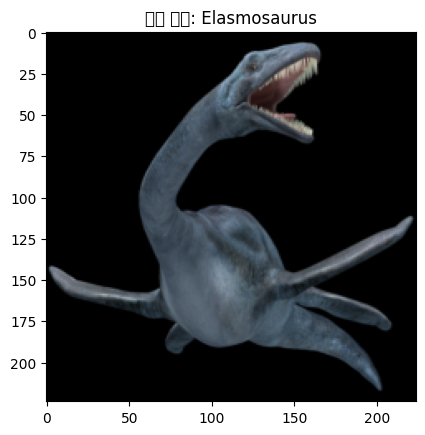

[예측 결과: Pachycephalosaurus, Compsognathus] (실제 정답: Pachycephalosaurus)


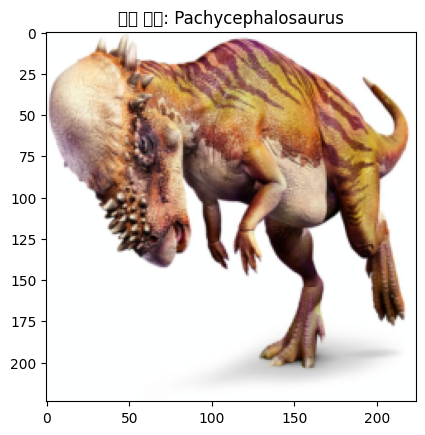

[예측 결과: Triceratops, Lambeosaurus] (실제 정답: Triceratops)


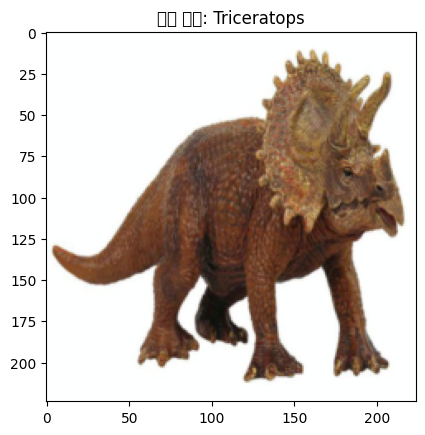

[예측 결과: Dimorphodon, Stegosaurus] (실제 정답: Dimorphodon)


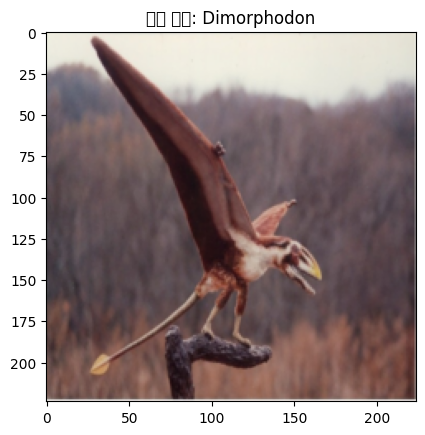

[예측 결과: Ankylosaurus, Parasaurolophus] (실제 정답: Ankylosaurus)


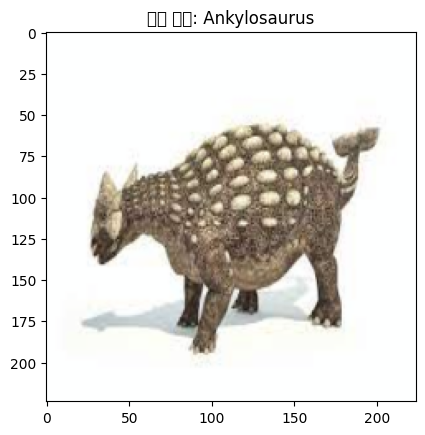

[예측 결과: Dimetrodon, Tyrannosaurus] (실제 정답: Dimetrodon)


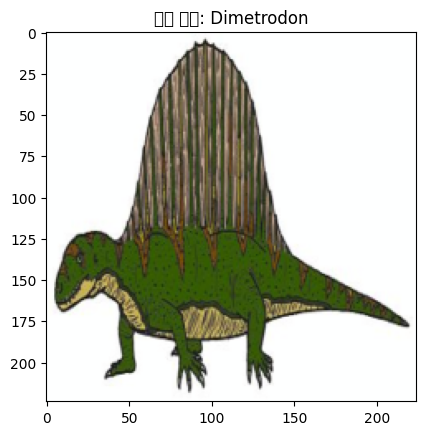

[예측 결과: Brachiosaurus, Elasmosaurus] (실제 정답: Brachiosaurus)


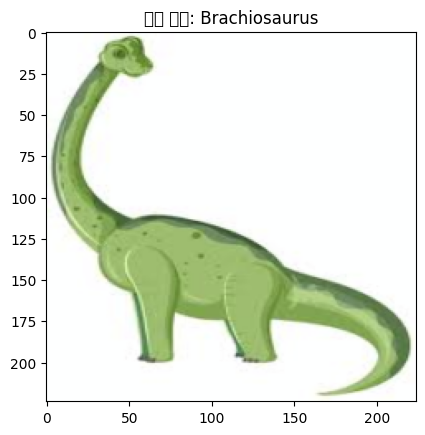

[예측 결과: Dimorphodon, Ouranosaurus] (실제 정답: Dimorphodon)


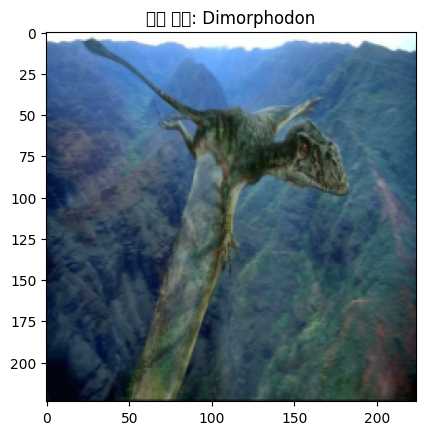

[예측 결과: Dilophosaurus, Giganotosaurus] (실제 정답: Dilophosaurus)


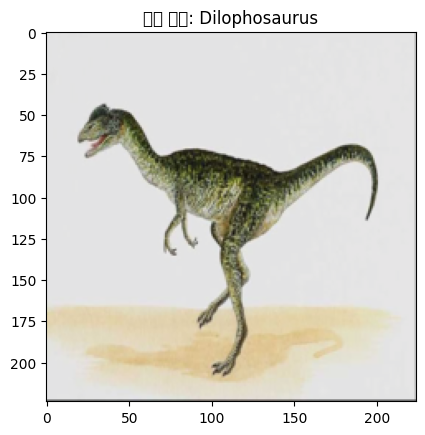

[예측 결과: Mosasaurus, Elasmosaurus] (실제 정답: Mosasaurus)


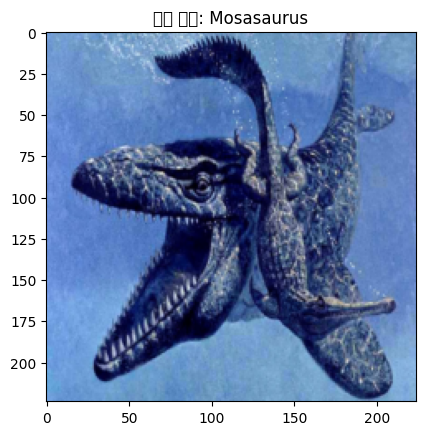

[예측 결과: Pteranodon, Kentrosaurus] (실제 정답: Pteranodon)


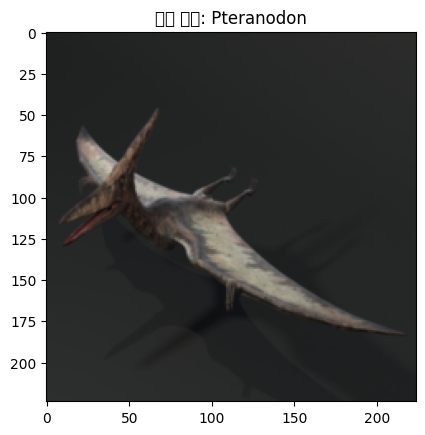

[예측 결과: Chasmosaurus, Pteranodon] (실제 정답: Chasmosaurus)


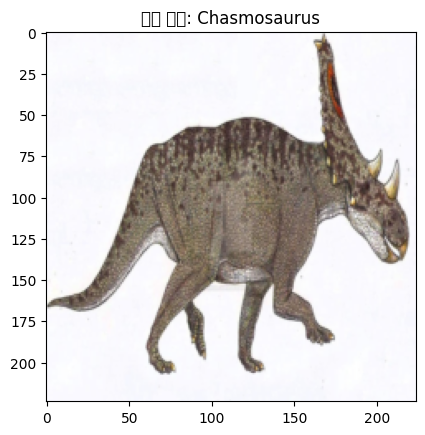

[예측 결과: Kentrosaurus, Oviraptor] (실제 정답: Kentrosaurus)


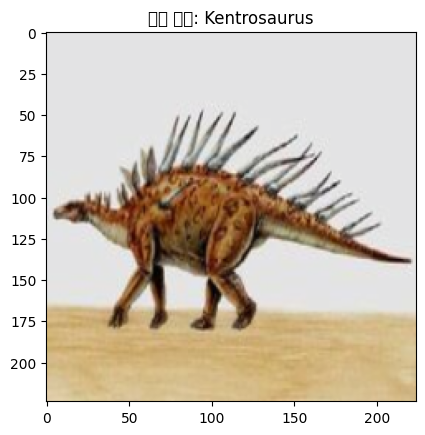

[예측 결과: Chasmosaurus, Ouranosaurus] (실제 정답: Chasmosaurus)


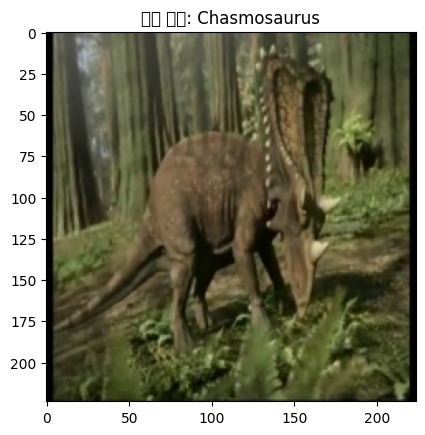

[예측 결과: Spinosaurus, Argentinosaurus] (실제 정답: Spinosaurus)


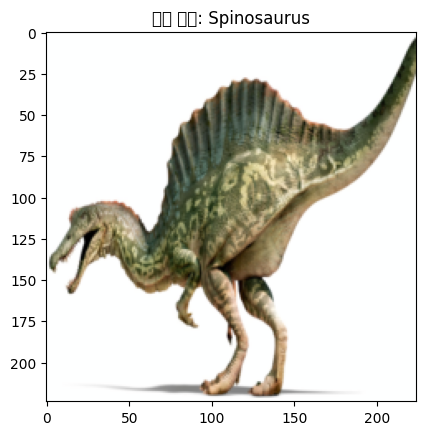

[예측 결과: Pteranodon, Iguanodon] (실제 정답: Pteranodon)


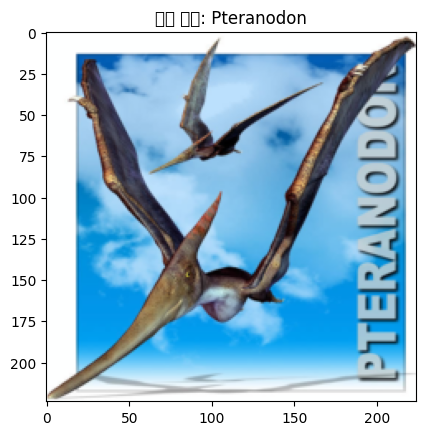

[예측 결과: Brachiosaurus, Incisibosaurus] (실제 정답: Brachiosaurus)


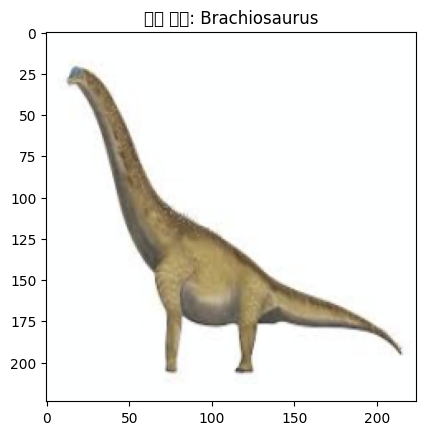

[Test Phase] Loss: 0.0883 Acc: 98.6667% Time: 4563.2492s


In [121]:
# 모델을 평가 모드로 설정
model.eval()

# PyTorch의 연산 그래프에서 이전 계산에서 계산한 gradient를 기록하지 않고 연산을 수행하는 context 
# 테스트 단계에서 모델의 평가를 수행할 때 사용
with torch.no_grad():
    # 각각 전체 loss와 정확도를 누적하는 변수
    # 테스트 데이터셋의 모든 배치를 순회하면서 모델의 예측과 정답을 비교하여 loss와 정확도를 누적
    running_loss = 0.
    running_corrects = 0
    
    # 배치 단위로 나눈 학습 데이터 순회하며 불러와서
    for inputs, labels in test_dataloader:
        # 입력 이미지 데이터 / GPU를 사용하기 위해 .to(device) 메소드를 사용
        inputs = inputs.to(device)
        # 해당 이미지의 정답 라벨
        labels = labels.to(device)

        # 모델에 학습 데이터를 입력 (forward propagation이 이루어지며, 모델은 입력을 받아 출력값을 계산)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        # 모델이 예측한 출력값 outputs와 실제 정답인 라벨 labels를 비교하여 손실 값을 계산
        loss = criterion(outputs, labels)

        # 이번 배치에서 계산된 손실 값과 정확도를 running_loss와 running_corrects 변수에 더함
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

        # 이미지의 예측결과와 실제 정답을 출력
        print(f'[예측 결과: {class_names[preds[0]]}, {class_names[preds[1]]}] (실제 정답: {class_names[labels.data[0]]})')
        # 해당 이미지를 출력하고 예측결과를 같이 보여줌
        imshow(inputs.cpu().data[0], title='예측 결과: ' + class_names[preds[0]])
    
    # 모든 배치에서 계산된 손실 값과 정확도를 이용하여 epoch 단위로 평균 손실 값과 정확도를 계산
    epoch_loss = running_loss / len(test_datasets)
    epoch_acc = running_corrects / len(test_datasets) * 100.
    
    # 손실값을 데이터에 append
    val_losses.append(epoch_loss)

    
    # 테스트 과정 중에 결과 출력
    print('[Test Phase] Loss: {:.4f} Acc: {:.4f}% Time: {:.4f}s'.format(epoch_loss, epoch_acc, time.time() - start_time))

In [118]:
# 모델 저장
torch.save(model, 'model.pth')

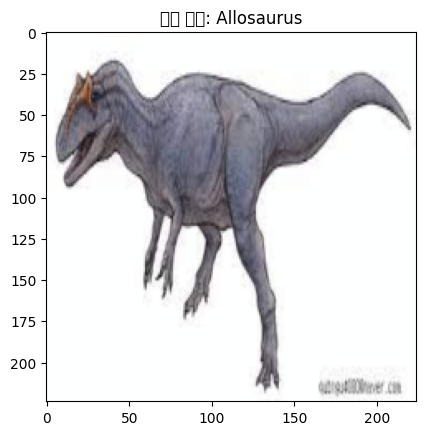

Allosaurus


In [119]:
from PIL import Image
# 분류를 위한 이미지를 열어서 image로 저장
image = Image.open('test_image.jpg')
# 저장한 이미지를 전처리(unsqueeze를 이용해 배치 차원을 추가하고, GPU를 사용)
image = transforms_test(image).unsqueeze(0).to(device)

# 모델의 파라미터가 업데이트 되지 않고 연산의 중복을 막아 빠른 결과를 출력
with torch.no_grad():
    # model에 image를 넣어 예측
    outputs = model(image)
    # torch.max 함수를 이용해 출력값 중 가장 큰 값을 가지는 인덱스
    _, preds = torch.max(outputs, 1)
    # 이미지와 예측 결과를 함께 시각화
    imshow(image.cpu().data[0], title='예측 결과: ' + class_names[preds[0]])
    print(class_names[preds])    

In [120]:
from PIL import Image
import torch.nn.functional as F

# 분류를 위한 이미지를 열어서 image로 저장
image = Image.open('test_image.jpg')
print(image)
print(11111111111, type(image))

# 저장한 이미지를 전처리(unsqueeze를 이용해 배치 차원을 추가하고, GPU를 사용)
image = transforms_test(image).unsqueeze(0).to(device)

# 모델의 파라미터가 업데이트 되지 않고 연산의 중복을 막아 빠른 결과를 출력
with torch.no_grad():
    # model에 image를 넣어 예측
    outputs = model(image)
    
    # softmax 함수를 이용하여 클래스별 확률 분포로 변환
    probs = F.softmax(outputs, dim=1)
    
    # 출력값 중 가장 높은 값을 가지는 인덱스를 이용하여 예측 결과 추출
    _, preds = torch.max(probs, 1)
    
    # 클래스별 확률 분포 출력
    for i in range(len(class_names)):
        print('{}: {:.2f}%'.format(class_names[i], probs[0, i]*100))

<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=336x150 at 0x7FB9BF7025B0>
11111111111 <class 'PIL.JpegImagePlugin.JpegImageFile'>
Allosaurus: 97.37%
Ankylosaurus: 0.00%
Argentinosaurus: 0.00%
Brachiosaurus: 0.00%
Chasmosaurus: 0.00%
Chintaosaurus: 0.00%
Compsognathus: 0.00%
Dilophosaurus: 0.00%
Dimetrodon: 0.00%
Dimorphodon: 0.00%
Elasmosaurus: 0.00%
Giganotosaurus: 0.00%
Iguanodon: 0.00%
Incisibosaurus: 0.00%
Kentrosaurus: 0.00%
Lambeosaurus: 0.00%
Mosasaurus: 0.00%
Nodosaurus: 0.00%
Ouranosaurus: 0.00%
Oviraptor: 0.00%
Pachycephalosaurus: 0.00%
Parasaurolophus: 0.00%
Pteranodon: 0.00%
Quetzalcoatlus: 0.00%
Sauropaganax: 2.61%
Spinosaurus: 0.00%
Stegosaurus: 0.00%
Triceratops: 0.00%
Tyrannosaurus: 0.02%
Velociraptor: 0.00%
